# Two-Tower Recommendation Model Evaluation
#
### **Objective:** Evaluate the performance of the pre-trained two-tower recommendation model using standard offline metrics and visualize the results.

## 1. Setup and Configuration

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import json
from typing import Dict, List, Tuple, Any, Set
from sklearn.model_selection import train_test_split # Or use custom splitting logic
# from tqdm.notebook import tqdm # Progress bar for loops
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
notebook_dir = os.getcwd() # Or specify the correct root project directory
project_root = os.path.dirname(notebook_dir) # Go up one level if notebook is in a 'notebooks' folder
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Import your custom classes ---
try:
    from src.data_preprocessor import DataPreprocessor
    from src.dataset import Dataset
    from src.simple_two_tower_model import SimpleTwoTowerModel
    from src.evaluate import ModelEvaluator # Your evaluator class
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Ensure the notebook is run from a location where 'src' is accessible or adjust sys.path.")
    # You might need to adjust the paths based on your project structure

In [3]:
MODEL_PATH = './model/best_model.pth'             # Path to your trained model checkpoint
MODEL_INFO_PATH = './model/model_info.json'       # Path to model metadata
DATA_DIR = "./src/data/exported_data/"              # Path to exported data CSVs/JSONs
K = 10                                                   # Top-K recommendations to evaluate (e.g., 5, 10, 20)
MIN_INTERACTIONS_FOR_TEST = 3                            # Min interactions a user needs to be included in test set
TEST_SET_STRATEGY = 'last_n'                             # 'last_n' or 'random_percent'
TEST_SET_VALUE = 1                                       # N for 'last_n', or percentage (e.g., 0.2) for 'random_percent'

# Set plot style
sns.set_theme(style="whitegrid")

## 2. Load Model and Data via Evaluator

In [4]:
try:
    evaluator = ModelEvaluator(
        model_path=MODEL_PATH,
        model_info_path=MODEL_INFO_PATH,
        data_dir=DATA_DIR
    )
    print("ModelEvaluator initialized successfully.")
    print(f"Model loaded from: {MODEL_PATH}")
    print(f"Data loaded from: {DATA_DIR}")
    print("-" * 30)
    print(f"Number of users in dataset: {len(evaluator.data['users'])}")
    print(f"Number of dishes in dataset: {len(evaluator.data['dishes'])}")
    print(f"Number of interactions: {len(evaluator.data['interactions'])}")
    print(f"Dish embeddings cached: {len(evaluator.dish_embeddings_cache)}")

    # Display sample data
    print("\nSample Users:")
    print(evaluator.data['users'].head(3))
    print("\nSample Dishes:")
    print(evaluator.data['dishes'].head(3))
    print("\nSample Interactions:")
    print(evaluator.data['interactions'].head(3))

except Exception as e:
    print(f"Error initializing ModelEvaluator: {e}")
    # Stop execution if evaluator fails to load
    raise

Loaded mock data:
  - Users: 13
  - Dishes: 20
  - Interactions: 297
  - Stores: 9
  - Food_tags: 98
  - Taste_tags: 33
  - Cooking_method_tags: 17
  - Culture_tags: 14
Loaded DataFrame columns: Index(['id', 'name', 'description', 'price', 'category', 'store_id',
       'stock_status', 'stock_count', 'rating', 'created_at', 'updated_at',
       'food_tags', 'taste_tags', 'cooking_method_tags', 'culture_tags'],
      dtype='object')
Cannot load file
Recreated name-to-id tag maps for preference matching.
Caching all dish embeddings...
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combi

e:\GraduationProject\backend\rec_sys\server\src\data_preprocessor.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['dishes']['rating'].fillna(3.0, inplace=True) # Fill NaN ratings


## 3. Prepare Evaluation Data (Train/Test Split)

We need to create a held-out test set from the interaction data to evaluate the model's ability to predict unseen interactions.

**Strategy:** We'll use the chosen `TEST_SET_STRATEGY`.
   - `last_n`: For each user with enough interactions, hold out their last `N` interactions for testing.
   - `random_percent`: For each user, randomly hold out a percentage of their interactions.

**Important:** The model loaded by `ModelEvaluator` should ideally have been trained *without* seeing the test interactions. This notebook simulates evaluating a pre-trained model against a test set derived from the *full* interaction data available *now*.

In [5]:
interactions_df = evaluator.data['interactions'].copy()
# Ensure timestamp is datetime for sorting
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])

# Filter users with minimum interactions
user_interaction_counts = interactions_df['user_id'].value_counts()
users_for_test = user_interaction_counts[user_interaction_counts >= MIN_INTERACTIONS_FOR_TEST].index.tolist()
print(f"Total users: {interactions_df['user_id'].nunique()}")
print(f"Users eligible for test set (>= {MIN_INTERACTIONS_FOR_TEST} interactions): {len(users_for_test)}")

test_interactions_list = []
train_interactions_list = [] # Keep track of train data used for generating ground truth

interactions_df_filtered = interactions_df[interactions_df['user_id'].isin(users_for_test)]
grouped_interactions = interactions_df_filtered.sort_values('timestamp').groupby('user_id')

print(f"Splitting data using strategy: '{TEST_SET_STRATEGY}' with value: {TEST_SET_VALUE}")

for user_id, group in tqdm(grouped_interactions, desc="Splitting Interactions"):
    if TEST_SET_STRATEGY == 'last_n':
        n = int(TEST_SET_VALUE)
        test_user_interactions = group.tail(n)
        train_user_interactions = group.head(-n)
    elif TEST_SET_STRATEGY == 'random_percent':
        test_size = int(len(group) * TEST_SET_VALUE)
        if test_size == 0 and len(group) > 0: # Ensure at least 1 test item if possible
             test_size = 1
        if test_size < len(group):
            test_user_interactions = group.sample(n=test_size, random_state=42)
            train_user_interactions = group.drop(test_user_interactions.index)
        else: # Handle cases where split results in full group as test (shouldn't happen with MIN_INTERACTIONS_FOR_TEST)
             test_user_interactions = group
             train_user_interactions = pd.DataFrame(columns=group.columns) # Empty df
    else:
        raise ValueError("Invalid TEST_SET_STRATEGY")

    test_interactions_list.append(test_user_interactions)
    train_interactions_list.append(train_user_interactions)

test_df = pd.concat(test_interactions_list)
# train_df = pd.concat(train_interactions_list) # We don't necessarily need train_df unless retraining here

# --- Create Ground Truth ---
# Map each test user to the set of dish IDs they interacted with in the test set
ground_truth: Dict[str, Set[str]] = test_df.groupby('user_id')['dish_id'].agg(set).to_dict()

print(f"\nCreated test set with {len(test_df)} interactions for {len(ground_truth)} users.")
print(f"Example ground truth entry: {list(ground_truth.items())[0] if ground_truth else 'N/A'}")

# --- Users to Evaluate ---
test_user_ids = list(ground_truth.keys())

Total users: 10
Users eligible for test set (>= 3 interactions): 10
Splitting data using strategy: 'last_n' with value: 1


Splitting Interactions: 100%|██████████| 10/10 [00:00<00:00, 10003.11it/s]


Created test set with 10 interactions for 10 users.
Example ground truth entry: ('68ea026c04589194166b9e48', {'68f45577dd01f7b3d32648b3'})


## 4. Generate Recommendations for Test Users

In [6]:
recommendations: Dict[str, List[Tuple[str, float]]] = {}
failed_users = []

for user_id in tqdm(test_user_ids, desc="Generating Recommendations"):
    try:
        # Use the evaluator's method to get top-K recommendations
        # This assumes get_recommendations uses the pre-trained model
        recs = evaluator.get_recommendations(user_id, top_k=K)
        recommendations[user_id] = recs
    except Exception as e:
        # Handle cases where user might not be in the model's vocabulary
        # (though ideally, the split should ensure test users have training data)
        print(f"Warning: Could not get recommendations for user {user_id}. Error: {e}")
        failed_users.append(user_id)

print(f"\nGenerated recommendations for {len(recommendations)} users.")
if failed_users:
     print(f"Failed to get recommendations for {len(failed_users)} users: {failed_users}")

# Remove failed users from ground truth and test list for metric calculation
for user_id in failed_users:
    if user_id in ground_truth:
        del ground_truth[user_id]
test_user_ids = list(ground_truth.keys()) # Update the list of users we have metrics for

print(f"Example recommendations entry: {list(recommendations.items())[0] if recommendations else 'N/A'}")

Generating Recommendations:   0%|          | 0/10 [00:00<?, ?it/s]

Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.


Generating Recommendations: 100%|██████████| 10/10 [00:00<00:00, 145.72it/s]

Created combined tag vocabulary with 74 unique tag IDs.
Created combined tag vocabulary with 74 unique tag IDs.

Generated recommendations for 10 users.
Example recommendations entry: ('68ea026c04589194166b9e48', [('68f45577dd01f7b3d32648bf', -0.9986121654510498), ('68f45577dd01f7b3d32648b1', -0.9986168146133423), ('68f45577dd01f7b3d32648c3', -0.9989659190177917), ('68f45577dd01f7b3d32648c2', -0.9990020990371704), ('68f45577dd01f7b3d32648b9', -0.999045729637146), ('68f45577dd01f7b3d32648c1', -0.9990615844726562), ('68f45577dd01f7b3d32648b7', -0.9990677833557129), ('68f45577dd01f7b3d32648b2', -0.9990795254707336), ('68f45577dd01f7b3d32648bd', -0.9990874528884888), ('68f45577dd01f7b3d32648c0', -0.9990890026092529)])


## 5. Define and Calculate Evaluation Metrics

 We will calculate the following standard metrics averaged across all test users:
 - **Precision@K:** Proportion of recommended items in the top-K that are relevant.
 - **Recall@K:** Proportion of relevant items that are found in the top-K recommendations.
 - **Hit Rate@K:** Proportion of users for whom at least one relevant item was recommended in the top-K.
 - **NDCG@K (Normalized Discounted Cumulative Gain):** Measures ranking quality, giving higher scores for relevant items ranked higher.
 - **MRR@K (Mean Reciprocal Rank):** The average of the reciprocal ranks of the *first* relevant item found in the top-K recommendations for each user.

In [7]:
# --- Metric Calculation Functions ---
def precision_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if k == 0: return 0.0
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return hits / k

def recall_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if not relevant_items: return 0.0 # Handle case with no relevant items
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return hits / len(relevant_items)

def hit_rate_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return 1.0 if hits > 0 else 0.0

def dcg_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    dcg = 0.0
    for i, item_id in enumerate(recommended_items[:k]):
        if item_id in relevant_items:
            dcg += 1.0 / np.log2(i + 2) # Rank is i+1, log base 2 of rank+1
    return dcg

def ndcg_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if not relevant_items: return 0.0
    ideal_k = min(k, len(relevant_items))
    ideal_dcg = dcg_at_k(list(relevant_items)[:ideal_k], relevant_items, ideal_k) # Ideal DCG uses perfect ranking
    if ideal_dcg == 0: return 0.0
    actual_dcg = dcg_at_k(recommended_items, relevant_items, k)
    return actual_dcg / ideal_dcg

def mrr_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    rec_k = recommended_items[:k]
    for i, item_id in enumerate(rec_k):
        if item_id in relevant_items:
            return 1.0 / (i + 1) # Return reciprocal rank of first hit
    return 0.0 # No relevant item found in top-K

# --- Calculate Metrics for All Test Users ---
results = {
    'precision': [],
    'recall': [],
    'hit_rate': [],
    'ndcg': [],
    'mrr': []
}

if not test_user_ids:
    print("No users left in the test set after attempting recommendation generation. Cannot calculate metrics.")
else:
    for user_id in tqdm(test_user_ids, desc="Calculating Metrics"):
        relevant = ground_truth.get(user_id, set())
        recommended_tuples = recommendations.get(user_id, [])
        recommended_ids = [item_id for item_id, score in recommended_tuples] # Extract just IDs

        if not relevant: # Skip users with no ground truth items (shouldn't happen with our split)
             continue

        results['precision'].append(precision_at_k(recommended_ids, relevant, K))
        results['recall'].append(recall_at_k(recommended_ids, relevant, K))
        results['hit_rate'].append(hit_rate_at_k(recommended_ids, relevant, K))
        results['ndcg'].append(ndcg_at_k(recommended_ids, relevant, K))
        results['mrr'].append(mrr_at_k(recommended_ids, relevant, K))

    # --- Calculate Average Metrics ---
    avg_metrics = {metric: np.mean(values) if values else 0.0 for metric, values in results.items()}

    print(f"\n--- Average Metrics @{K} ---")
    for metric, value in avg_metrics.items():
        print(f"{metric.upper():<10}: {value:.4f}")

Calculating Metrics: 100%|██████████| 10/10 [00:00<00:00, 18816.98it/s]


--- Average Metrics @10 ---
PRECISION : 0.0500
RECALL    : 0.5000
HIT_RATE  : 0.5000
NDCG      : 0.2479
MRR       : 0.1667


## 6. Visualize Results 📊

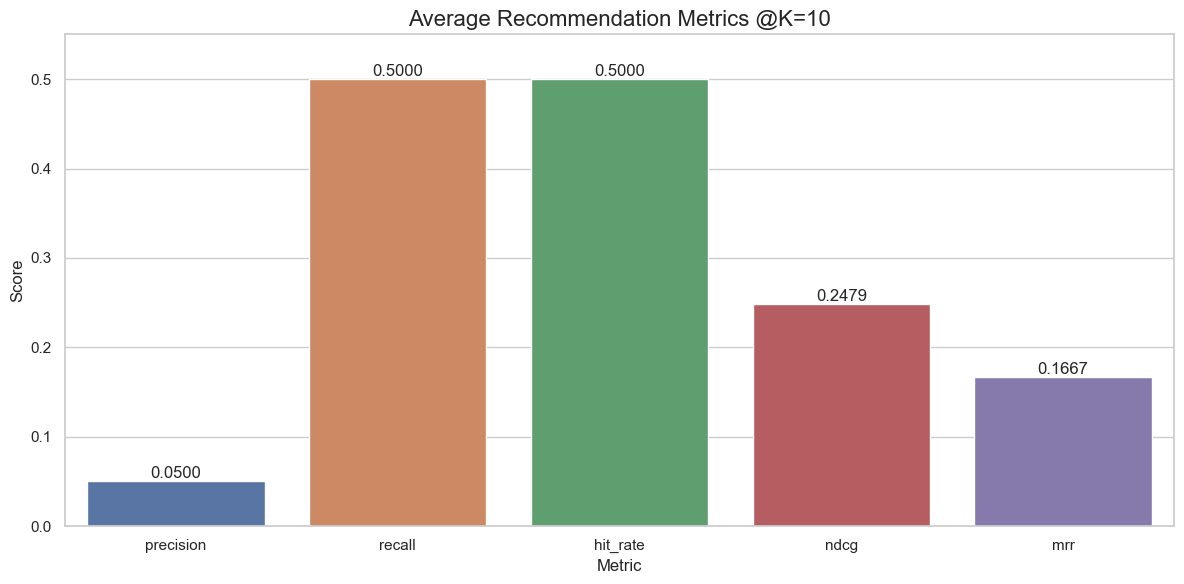

In [8]:
if avg_metrics:
    metrics_df = pd.DataFrame([avg_metrics])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=metrics_df)
    ax.set_title(f'Average Recommendation Metrics @K={K}', fontsize=16)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylim(0, max(metrics_df.max().max() * 1.1, 0.1)) # Adjust y-limit

    # Add score labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate visualization as no metrics were calculated.")

## 7. Qualitative Evaluation: Cold Start Example

 Let's test the cold-start user scenario using the evaluator's built-in function to see if the recommendations align qualitatively with the provided preferences.

In [9]:
# Define a sample cold-start profile (adjust as needed)
cold_start_profile = {
    "user_profile": {
        "age": 30,
        "gender": "female",
        "location": "Ho Chi Minh City",
        "preferences": {
            "cuisine": ["Việt Nam", "Nhật Bản"],
            "taste": ["không cay", "đậm đà"],
            "price_range": "medium" # Or 'budget', 'premium', 'any'
        }
    }
}

try:
    cold_start_results = evaluator.evaluate_cold_start_user(cold_start_profile)

    print("\n--- Cold Start User Evaluation ---")
    print(f"Scenario Profile: {cold_start_profile['user_profile']}")
    print("-" * 20)
    print("Analysis:")
    for key, value in cold_start_results.get('analysis', {}).items():
        print(f"  {key}: {value:.2f}%" if isinstance(value, (int,float)) else f"  {key}: {value}")
    print("-" * 20)
    print(f"Top {K} Recommendations:")
    recs = cold_start_results.get('recommendations', [])
    if not recs:
        print("  No recommendations generated.")
    else:
        # Fetch dish names for better readability
        dish_names_map = evaluator.data['dishes'].set_index('id')['name'].to_dict()
        for i, (dish_id, score) in enumerate(recs[:K]):
            dish_name = dish_names_map.get(dish_id, f"Unknown Dish ({dish_id})")
            print(f"  {i+1}. {dish_name} (Score: {score:.4f})")

except Exception as e:
    print(f"\nError during cold start evaluation: {e}")


=== COLD START USER EVALUATION ===
Generating cold-start embedding for preferences: {'cuisine': ['Việt Nam', 'Nhật Bản'], 'taste': ['không cay', 'đậm đà'], 'price_range': 'medium'}

--- Cold Start User Evaluation ---
Scenario Profile: {'age': 30, 'gender': 'female', 'location': 'Ho Chi Minh City', 'preferences': {'cuisine': ['Việt Nam', 'Nhật Bản'], 'taste': ['không cay', 'đậm đà'], 'price_range': 'medium'}}
--------------------
Analysis:
  total_recommendations: 10.00%
  cuisine_alignment: 0.00%
  price_alignment: 0.00%
  taste_alignment: 0.00%
--------------------
Top 10 Recommendations:
  1. Chè Đậu Đỏ (Score: 0.9999)
  2. Cơm Tấm Sườn Nướng (Score: 0.9999)
  3. Mango Sticky Rice (Score: 0.9999)
  4. Ramen Tonkotsu (Score: 0.9999)
  5. Pad Thai Fusion (Score: 0.9999)
  6. Sushi Salmon Roll (Score: 0.9999)
  7. Canh Chua Cá Lóc (Score: 0.9999)
  8. Korean BBQ Bulgogi (Score: 0.9999)
  9. Kung Pao Chicken (Score: 0.9999)
  10. Bánh Mì Thịt Nướng (Score: 0.9999)


 **Interpretation:**
 - Review the cold-start recommendations. Do they generally match the specified `cuisine`, `taste`, and `price_range`?
 - Check the `analysis` section (if provided by your `evaluate_cold_start_user` function) - does the alignment percentage seem reasonable?

 ## 8. Conclusion

 This notebook evaluated the pre-trained two-tower model:
 - **Quantitative Metrics:** Precision, Recall, Hit Rate, NDCG, and MRR at K={K} were calculated. The scores indicate [**Interpret the scores here - e.g., "reasonable performance", "potential for improvement", "strong ranking ability based on NDCG"**].
 - **Qualitative Check:** The cold-start example suggests the model [**Interpret the cold start - e.g., "can generate plausible recommendations based on preferences", "struggles with specific taste profiles"**].

 **Proof of Learning:** Non-zero metric scores (significantly better than random chance) demonstrate that the model **has learned patterns** from the training data to make relevant predictions. Higher scores indicate better learning.